# Microsoft Learn

## AutoML for Images to train and a deploy an image classification model (part 1)

**Important:** This feature is currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see [Supplemental Terms of Use for Microsoft Azure Previews](https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/).

Serge Retkowsky | serge.retkowsky@microsoft.com | V1 14-June-2022

### Agenda:
In this notebook you will:
- Create an Azure ML experiment
- Download some images files to train a classification model. In this example we will try to classify flowers from images
- Use AutoML for Images to build and train an image classification model
- Do some advanced hyperparameter tuning using AutoML for Images advanced options
- Deploy the computer vision model into Azure Kubernetes Service
- Test the model

### AutoML for Images links:
What is AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml#computer-vision-preview

Algorithms<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

Tutorials<br>
https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-auto-train-image-models

ONNX<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-inference-onnx-automl-image-models?tabs=multi-class

How to use AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-automl-small-object-detect<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models

## 1. Environment setup

In [120]:
import numpy as np
import json
import os
import urllib
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import requests
import os.path
import humanize
from os import path
import time
import cv2

In [2]:
print("Today:", datetime.datetime.now())

Today: 2022-06-14 12:13:44.042494


In [3]:
import sys
print("Python version =", sys.version)

Python version = 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [5]:
import azureml.core
print("This notebooks was made using Azure ML version 1.41")
print("Azure ML version =", azureml.core.VERSION)

This notebooks was made using Azure ML version 1.41
Azure ML version = 1.41.0


In [6]:
# Your local environment

def getSystemInfo():
    import platform, socket, re, uuid, json, psutil, logging
    
    try:
        info = {}
        info['Platform'] = platform.system()
        info['Platform-release'] = platform.release()
        info['Platform-version'] = platform.version()
        info['Architecture'] = platform.machine()
        info['Hostname'] = socket.gethostname()
        info['IP-address'] = socket.gethostbyname(socket.gethostname())
        info['MAC-address'] = ':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor'] = platform.processor()
        info['RAM'] = str(round(psutil.virtual_memory().total / (1024.0 **3))) + " Gb"
        return json.dumps(info)
    
    except Exception as e:
        logging.exception(e)

print("Local environment:")
json.loads(getSystemInfo())

Local environment:


{'Platform': 'Linux',
 'Platform-release': '5.4.0-1077-azure',
 'Platform-version': '#80~18.04.1-Ubuntu SMP Wed Apr 13 02:07:09 UTC 2022',
 'Architecture': 'x86_64',
 'Hostname': 'standardd13',
 'IP-address': '127.0.0.1',
 'MAC-address': '60:45:bd:90:9b:99',
 'Processor': 'x86_64',
 'RAM': '55 Gb'}

In [7]:
def listfiles(MYDIR):
    
    print("Files in:", MYDIR, "\n")
    for file in os.scandir(MYDIR):
         print(datetime.datetime.fromtimestamp(file.stat().st_atime), 
               file.name, humanize.naturalsize(file.stat().st_size))

## 2. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

> Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [8]:
subscription_id = os.environ.get("SUBSCRIPTION_ID", "70b8f39e-8863-49f7-b6ba-34a80799550c")
resource_group = os.environ.get("RESOURCE_GROUP", "azuremlvision-rg")
workspace_name = os.environ.get("WORKSPACE_NAME", "azuremlvision")

In [9]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id = subscription_id, 
                   resource_group = resource_group, 
                   workspace_name = workspace_name)
    ws.write_config()
    print("[OK] Workspace configuration saved.")

except:
    print("[Error] Workspace not found!")

[OK] Workspace configuration saved.


In [10]:
try:
    print("Loading Azure ML workspace config...")
    ws = Workspace.from_config()
    # ws.get_details()
    print("\n[OK] Workspace is available:")
    print("Azure ML workspace:", ws.name)
    print("Azure ML resource group:", ws.resource_group)

except:
    print("[Error] Cannot load configuration")

Loading Azure ML workspace config...

[OK] Workspace is available:
Azure ML workspace: azuremlvision
Azure ML resource group: azuremlvision-rg


## 3. Azure ML GPU Compute target setup
**You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training.** <br><br>
**AutoML models for image tasks require GPU SKUs and support NC and ND families.** We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [11]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpucluster"

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")
    
except KeyError:
    print("Creating a new compute target...")
    
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown = 1200,
        min_nodes = 0,
        max_nodes = 4,
    )
    
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.

compute_target.wait_for_completion(
    show_output = True, min_node_count = None, timeout_in_minutes = 20
)

Creating a new compute target...
InProgress.....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [12]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [13]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2022-06-14T12:14:40.751000+00:00',
 'errors': None,
 'creationTime': '2022-06-14T12:14:31.289261+00:00',
 'modifiedTime': '2022-06-14T12:14:55.994870+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1200S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [14]:
from azureml.core import Experiment

experiment_name = "AutomlforImages-FlowersClassification" #Name of your Azure ML experimentation
experiment = Experiment(ws, name=experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
AutomlforImages-FlowersClassification,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


## 5. Datasets
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

In [15]:
# Directory to store the images
IMAGES_DIR = 'flowers-images'

In [18]:
if path.os.path.isdir(IMAGES_DIR) :
    print("Directory:", IMAGES_DIR, "exists")

else:
    print("Creating directory:", IMAGES_DIR)
    os.mkdir(IMAGES_DIR)
    os.chdir(IMAGES_DIR)
    
    print("1. Download zip file...\n")
    # Downlading the images
    !wget https://www.dropbox.com/s/zkhyu9dic7olz86/flowers.zip
    
    print("2. Unzip file...\n")
    # Unzip the file in a quiet mode
    !unzip -qq flowers.zip
    
    print("3. Removing zip file...\n")
    os.remove("flowers.zip")
    
    os.chdir('..')
    print("Done")

Creating directory: flowers-images
1. Download zip file...

--2022-06-14 12:16:29--  https://www.dropbox.com/s/zkhyu9dic7olz86/flowers.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zkhyu9dic7olz86/flowers.zip [following]
--2022-06-14 12:16:29--  https://www.dropbox.com/s/raw/zkhyu9dic7olz86/flowers.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca61b9dc820a1662c0f4378509c.dl.dropboxusercontent.com/cd/0/inline/BnKiAJlOpO2eRzeQBbtP-e9Yk459rpp2NXQcDwC777eheU2SSE9SWrSbTuG1XB7RNLT2uAtRqk_b_GFUEtm_Nd-jbv5Se09KxJnbimWlk0mt8psOXAM64rHJCXuvOX0nfROUzh76uaBvXcQaoBxpGlrZu_yE7iGiDwouOby0KjYLNA/file# [following]
--2022-06-14 12:16:30--  https://uca61b9dc820a1662c0f4378509c.dl.dropboxusercontent.com/cd/0/inline/BnKiAJlO

### Images files

In [19]:
print("Images directory:", IMAGES_DIR)

Images directory: flowers-images


In [20]:
TRAIN_DIR = IMAGES_DIR + '/train'
TEST_DIR = IMAGES_DIR + '/test'

In [21]:
os.listdir(IMAGES_DIR)

['test', 'train']

In [22]:
os.listdir(TRAIN_DIR)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [23]:
os.listdir(TEST_DIR)

['test (1).jpg', 'test (2).jpg', 'test (3).jpg']

In [24]:
for root, _, files in os.walk(TRAIN_DIR):
    print(root, "=", len(files), "files")

flowers-images/train = 0 files
flowers-images/train/daisy = 100 files
flowers-images/train/dandelion = 100 files
flowers-images/train/roses = 100 files
flowers-images/train/sunflowers = 100 files
flowers-images/train/tulips = 99 files


In [25]:
for root, _, files in os.walk(TEST_DIR):
    print(root, "=", len(files), "files")

flowers-images/test = 3 files


### Some samples:

In [26]:
from IPython.display import Image

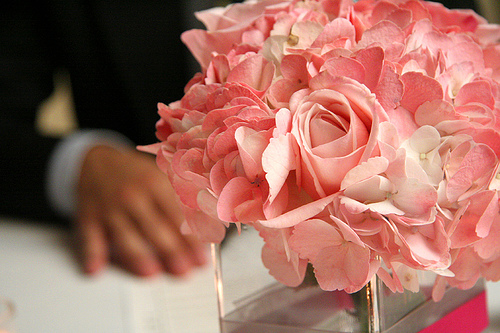

In [27]:
sample_image = TRAIN_DIR + '/roses/roses (1).jpg'
Image(filename = sample_image, width = 512, height = 512)

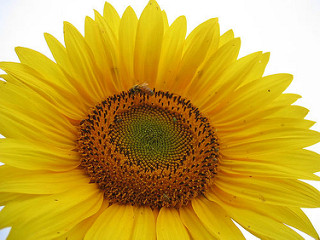

In [28]:
sample_image = TRAIN_DIR + '/sunflowers/sunflowers (1).jpg'
Image(filename = sample_image, width = 512, height = 512) 

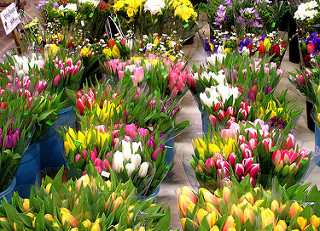

In [29]:
sample_image = TRAIN_DIR + '/tulips/tulips (1).jpg'
Image(filename = sample_image, width = 512, height = 512) 

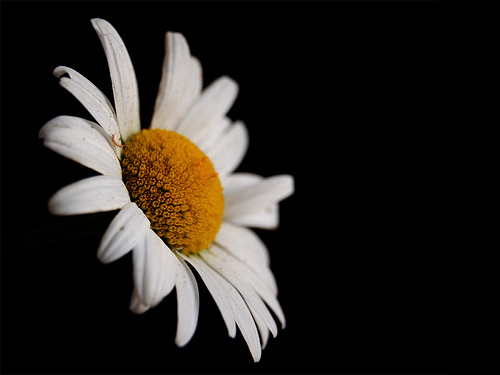

In [30]:
sample_image = TRAIN_DIR + '/daisy/daisy (1).jpg'
Image(filename = sample_image, width = 512, height = 512) 

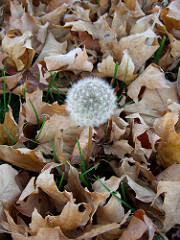

In [31]:
sample_image = TRAIN_DIR + '/dandelion/dandelion (1).jpg'
Image(filename = sample_image, width = 512, height = 512) 

### Convert the downloaded data to JSONL


In [32]:
SOURCE = "train" # training images dir

# Names for the JSONL files
TRAIN_JSONL = "train_annotations.jsonl"
VALID_JSONL = "validation_annotations.jsonl"

# Names for the datasets
training_dataset_name = "FlowersTrainingDataset"
validation_dataset_name = "FlowersValidationDataset"

In [34]:
src = "./" + IMAGES_DIR + "/" + SOURCE + "/"

train_validation_ratio = 5

# Retrieving default datastore that got automatically created when we setup a workspace
workspaceblobstore = ws.get_default_datastore().name

# Path to the training and validation files
train_annotations_file = os.path.join(src, TRAIN_JSONL)
validation_annotations_file = os.path.join(src, VALID_JSONL)

# sample json line dictionary
json_line_sample = {
    "image_url": "AmlDatastore://"
    + workspaceblobstore
    + "/"
    + os.path.basename(os.path.dirname(src)),
    "label": "",
}

index = 0

# Scan each sub directary and generate jsonl line
with open(train_annotations_file, "w") as train_f:
    
    with open(validation_annotations_file, "w") as validation_f:
        
        for className in os.listdir(src):
            subDir = src + className
            
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ./flowers-images/train/daisy
Parsing ./flowers-images/train/dandelion
Parsing ./flowers-images/train/roses
Parsing ./flowers-images/train/sunflowers
Parsing ./flowers-images/train/tulips


In [35]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir = './' + IMAGES_DIR + '/' + SOURCE, target_path = IMAGES_DIR + '/' + SOURCE)

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 501 files
Target already exists. Skipping upload for flowers-images/train/train_annotations.jsonl
Target already exists. Skipping upload for flowers-images/train/validation_annotations.jsonl
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (1).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (10).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (100).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (11).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (12).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (13).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (14).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (15).jpg
Target already exists. Skipping upload for flowers-images/train/daisy/daisy (16).jpg
Target already exi

Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (33).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (34).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (35).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (36).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (37).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (38).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (39).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (4).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (40).jpg
Target already exists. Skipping upload for flowers-images/train/dandelion/dandelion (41).jpg
Target already exists. Skipping upload for flowers-images/train/dandeli

Target already exists. Skipping upload for flowers-images/train/roses/roses (37).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (38).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (39).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (4).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (40).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (41).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (42).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (43).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (44).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (45).jpg
Target already exists. Skipping upload for flowers-images/train/roses/roses (46).jpg
Target already exists. Skipping upload for flowers-images/train/ro

Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (37).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (38).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (39).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (4).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (40).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (41).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (42).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (43).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (44).jpg
Target already exists. Skipping upload for flowers-images/train/sunflowers/sunflowers (45).jpg
Target already exists. Skipping upload for flowers-

Target already exists. Skipping upload for flowers-images/train/tulips/tulips (4).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (40).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (41).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (42).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (43).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (44).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (45).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (46).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (47).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (48).jpg
Target already exists. Skipping upload for flowers-images/train/tulips/tulips (49).jpg
Target already exists. Skipping upload for f

$AZUREML_DATAREFERENCE_fc795651b8c3479f90ccc7979c08b787

Finally, we need to create an Azure ML [Dataset](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores) from the data we uploaded to the Datastore. We create one dataset for training and one for validation.

In [36]:
from azureml.core import Dataset
from azureml.data import DataType

# get existing training dataset
#training_dataset_name = "flowersObjectsTrainingDataset"

if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print("Found the training dataset", training_dataset_name)

else:
    # create training dataset
    training_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path(IMAGES_DIR + '/' + SOURCE + '/' + TRAIN_JSONL),
        set_column_types = {"image_url": DataType.to_stream(ds.workspace)},
    )
    training_dataset = training_dataset.register(
        workspace = ws, name = training_dataset_name
    )
# get existing validation dataset
#validation_dataset_name = "flowersObjectsValidationDataset"

if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print("Found the validation dataset", validation_dataset_name)

else:
    # create validation dataset
    validation_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path(IMAGES_DIR + '/' + SOURCE + '/' + VALID_JSONL),
        set_column_types = {"image_url": DataType.to_stream(ds.workspace)},
    )
    validation_dataset = validation_dataset.register(
        workspace = ws, name = validation_dataset_name
    )

print("Training dataset name: " + training_dataset.name)
print("Validation dataset name: " + validation_dataset.name)

Training dataset name: FlowersTrainingDataset
Validation dataset name: FlowersValidationDataset


In [37]:
listfiles(TRAIN_DIR)

Files in: flowers-images/train 

2022-06-06 10:23:16 daisy 0 Bytes
2022-06-06 10:23:44 dandelion 0 Bytes
2022-06-06 10:24:02 roses 0 Bytes
2022-06-06 10:24:24 sunflowers 0 Bytes
2022-06-14 12:19:40.622564 train_annotations.jsonl 40.7 kB
2022-06-06 10:24:46 tulips 0 Bytes
2022-06-14 12:19:40.609572 validation_annotations.jsonl 10.2 kB


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the documentation for more details.

This is what the training dataset looks like

In [38]:
train_df = training_dataset.to_pandas_dataframe()

In [39]:
train_df.shape

(399, 2)

In [40]:
train_df.head()

,image_url,label
0,workspaceblobstore/train/daisy/daisy (10).jpg,daisy
1,workspaceblobstore/train/daisy/daisy (100).jpg,daisy
2,workspaceblobstore/train/daisy/daisy (11).jpg,daisy
3,workspaceblobstore/train/daisy/daisy (12).jpg,daisy
4,workspaceblobstore/train/daisy/daisy (14).jpg,daisy


In [41]:
# Counts images by labels
train_df['label'].value_counts()

sunflowers    80
dandelion     80
roses         80
daisy         80
tulips        79
Name: label, dtype: int64

In [42]:
# Percentage values
train_df['label'].value_counts(normalize = True)

sunflowers    0.200501
dandelion     0.200501
roses         0.200501
daisy         0.200501
tulips        0.197995
Name: label, dtype: float64

<AxesSubplot:title={'center':'Flowers category - Training'}>

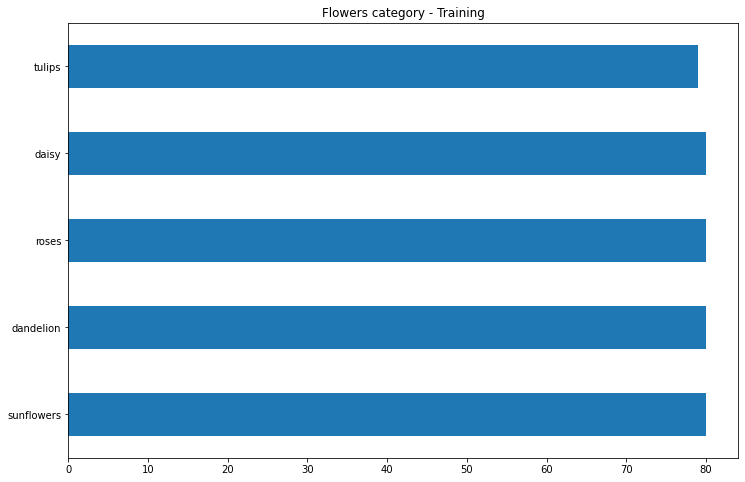

In [43]:
# Distribution of the training images
%matplotlib inline
plt.figure(figsize = (12, 8))
plt.title("Flowers category - Training")
train_df['label'].value_counts(sort = True).plot.barh()

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the 'AutoMLImageConfig' - please refer to the [documentation](https://github.com/swatig007/automlForImages#readme) for the details on the parameters that can be used and their values. 

Supported Algorithms
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones.<br><br>
### Using default hyperparameter values for the specified algorithm

Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.


In [44]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

In [45]:
CVMODEL = 'resnet18'

In [46]:
# AutoML Configuration
image_config = AutoMLImageConfig(
    task = ImageTask.IMAGE_CLASSIFICATION, # AutoML Vision task
    compute_target = compute_target, # Compute target
    training_data = training_dataset, # Training dataset
    validation_data = validation_dataset, # Validation dataset
    hyperparameter_sampling = GridParameterSampling(
        {'model_name': choice(CVMODEL)}), # Model to yse
    iterations = 1, # =1 because we specified 1 model to train
)

## 7. Submitting an AutoML run for Computer Vision tasks 
Once you've created the config settings for your run, **you can submit an AutoML run** using the config in order to train a vision model using your training dataset.

In [48]:
automl_image_run = experiment.submit(image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutomlforImages-FlowersClassification,AutoML_42edd3b0-cf9c-4101-8158-62a9670be98c,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [49]:
automl_image_run.wait_for_completion(wait_post_processing = True) # Wait until automl run is finished

{'runId': 'AutoML_42edd3b0-cf9c-4101-8158-62a9670be98c',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2022-06-14T12:21:28.953816Z',
 'endTimeUtc': '2022-06-14T12:36:44.393642Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpucluster',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlforImages-FlowersClassification","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"gpucluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":

In [50]:
# Directory to store the model and its results
MODEL_DIR = 'model'

In [51]:
if path.os.path.isdir(MODEL_DIR) :
    print("Directory:", MODEL_DIR, "exists")

else:
    print("Directory", MODEL_DIR, "did not exist.")
    print("Creating directory:", MODEL_DIR)
    os.mkdir(MODEL_DIR)
    print("Done.")

Directory model did not exist.
Creating directory: model
Done.


In [52]:
best_child_run = automl_image_run.get_best_child() # Get the model
best_child_run.download_file("confusion_matrix", 
                             output_file_path = MODEL_DIR + "/confusion_matrix_1.json")

In [55]:
with open(MODEL_DIR + "/confusion_matrix_1.json") as f:
    cm = json.load(f)

print("Confusion Matrix:\n")
print(cm['data']['class_labels'])
rowclass = 0

while rowclass < len(cm['data']['class_labels']):
    print(cm['data']['matrix'][rowclass])
    rowclass += 1

Confusion Matrix:

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
[17, 3, 0, 0, 0]
[0, 17, 0, 2, 1]
[1, 0, 16, 0, 3]
[0, 1, 1, 18, 0]
[1, 0, 1, 0, 18]


In [56]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
automlvisionmetrics

{'precision_score_macro': [0.49348,
  0.80753,
  0.82444,
  0.82158,
  0.81627,
  0.83008,
  0.83529,
  0.80762,
  0.85775,
  0.82977,
  0.84218,
  0.85374,
  0.86227,
  0.85374,
  0.86227],
 'average_precision_score_weighted': [0.45393,
  0.89535,
  0.92846,
  0.91272,
  0.92021,
  0.90322,
  0.93293,
  0.91526,
  0.94337,
  0.93938,
  0.93602,
  0.94611,
  0.94989,
  0.95287,
  0.95463],
 'AUC_weighted': [0.73275,
  0.95775,
  0.9725,
  0.96662,
  0.96312,
  0.96012,
  0.97463,
  0.9675,
  0.97963,
  0.97925,
  0.97838,
  0.98138,
  0.983,
  0.98438,
  0.98463],
 'f1_score_weighted': [0.14351,
  0.69799,
  0.77007,
  0.67798,
  0.66625,
  0.74997,
  0.81124,
  0.77209,
  0.84071,
  0.82839,
  0.83972,
  0.85018,
  0.86006,
  0.85018,
  0.86006],
 'average_precision_score_micro': [0.29694,
  0.79095,
  0.88276,
  0.81544,
  0.80525,
  0.82471,
  0.90485,
  0.86604,
  0.92512,
  0.93313,
  0.93044,
  0.9406,
  0.9454,
  0.94641,
  0.94889],
 'f1_score_macro': [0.14351,
  0.69799,
  0.7

In [57]:
print("Computer vision model metrics:\n")
print("Accuracy =", automlvisionmetrics['accuracy'][-1])
print("Precision =", automlvisionmetrics['classification_report']['precision'][-1])
print("Recall =", automlvisionmetrics['classification_report']['recall'][-1])
print("Auc =", automlvisionmetrics['classification_report']['auc'][-1])
print("Average precision =", automlvisionmetrics['classification_report']['average_precision'][-1])
print("F1 score =", automlvisionmetrics['classification_report']['f1-score'][-1])

Computer vision model metrics:

Accuracy = 0.86
Precision = 0.86227
Recall = 0.86
Auc = 0.98463
Average precision = 0.95463
F1 score = 0.86006


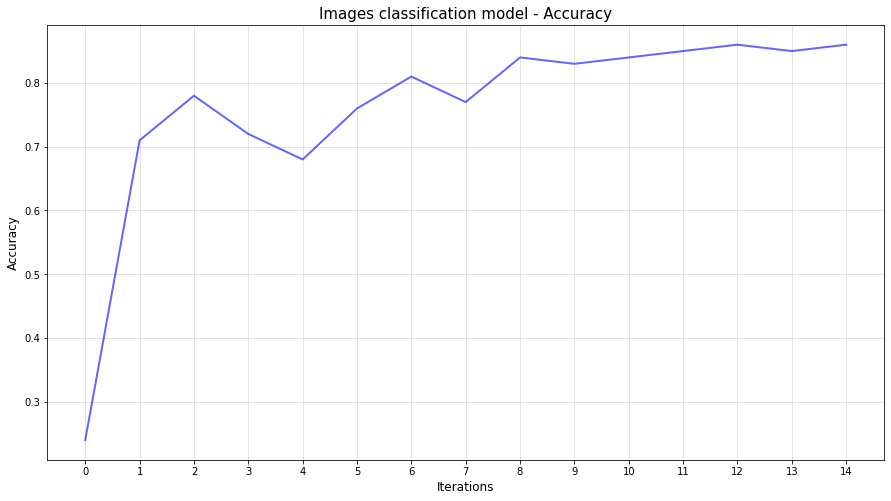

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(automlvisionmetrics['accuracy'], 'b-', alpha = 0.6, linewidth = 2)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.title('Images classification model - Accuracy', fontsize = 15)
plt.grid(color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))

plt.savefig(MODEL_DIR + '/accuracy_1.png')
plt.show()

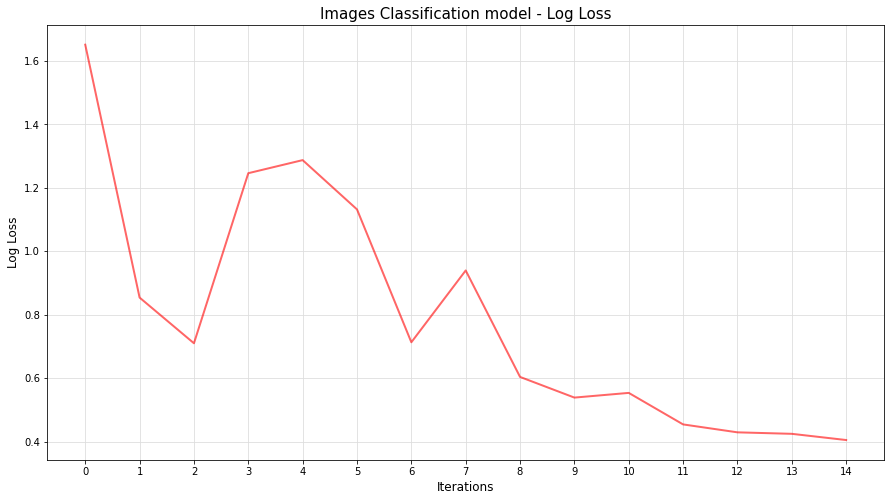

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(automlvisionmetrics['log_loss'], 'r-', lw = 2, alpha = 0.6)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Log Loss', fontsize = 12)
plt.title('Images Classification model - Log Loss', fontsize = 15)
plt.grid( color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))

plt.savefig(MODEL_DIR + '/logloss_1.png')
plt.show()

### Hyperparameter sweeping for your AutoML models for computer vision tasks

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space, to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, **choosing from a range of values for learning_rate, optimizer, lr_scheduler, etc, to generate a model with the optimal 'accuracy'.** If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use **Random Sampling to pick samples from this parameter space and try a total of 10 iterations** with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We also leverage the **Bandit early termination policy** that terminates poor performing configs (those that are not within 20% slack of the best perfroming config), thus significantly saving compute resources.

> Supported Algorithms
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

### List of model available for Image classification:

In [62]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "learning_rate": uniform(0.001, 0.01),
    "model": choice(
        {
            "model_name": choice("vitb16r224"),
            "number_of_epochs": choice(15, 30),
        },
        
        {
            "model_name": choice("seresnext", "seresnext"),
            "layers_to_freeze": choice(0, 1, 2, 3),
        },
        
    ),
}

tuning_settings = {
    "iterations": 10,
    "max_concurrent_iterations": 4,
    "hyperparameter_sampling": RandomParameterSampling(parameter_space),
    "early_termination_policy": BanditPolicy(evaluation_interval = 2, 
                                             slack_factor = 0.2, 
                                             delay_evaluation = 6),
}

automl_image_config = AutoMLImageConfig(
    task = ImageTask.IMAGE_CLASSIFICATION,
    compute_target = compute_target,
    training_data = training_dataset,
    validation_data = validation_dataset,
    **tuning_settings,
)

In [63]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutomlforImages-FlowersClassification,AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [64]:
automl_image_run.wait_for_completion(wait_post_processing = True)

{'runId': 'AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2022-06-14T12:44:14.549531Z',
 'endTimeUtc': '2022-06-14T13:12:05.663828Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpucluster',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlforImages-FlowersClassification","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"gpucluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_metric":

In [65]:
best_child_run = automl_image_run.get_best_child()

best_child_run.download_file("confusion_matrix",
                             output_file_path = MODEL_DIR + "/confusion_matrix_bestmodel.json")

In [66]:
best_child_run.properties

{'_azureml.ComputeTargetType': 'amlctrain',
 'ContentSnapshotId': '1d4295b6-dac0-4395-a353-b7254ed1753c',
 'ProcessInfoFile': 'azureml-logs/process_info.json',
 'ProcessStatusFile': 'azureml-logs/process_status.json',
 'score': '0.99',
 'model_name': 'AutoML27b99069d9',
 'runTemplate': 'automl_child',
 'run_algorithm': 'vitb16r224',
 'model_output_path': 'outputs/model.pt',
 'scoring_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53_HD_9/outputs/scoring_file_v_1_0_0.py',
 'conda_env_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53_HD_9/outputs/conda_env_v_1_0_0.yml',
 'model_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53_HD_9/outputs/model.pt'}

In [67]:
best_child_run.properties["model_name"]

'AutoML27b99069d9'

In [68]:
best_child_run.properties['run_algorithm']

'vitb16r224'

In [69]:
with open(MODEL_DIR + '/confusion_matrix_bestmodel.json') as f:
    print(json.load(f))

{'schema_type': 'confusion_matrix', 'schema_version': '1.0.0', 'data': {'class_labels': ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'], 'matrix': [[19, 0, 0, 1, 0], [0, 20, 0, 0, 0], [0, 0, 20, 0, 0], [0, 0, 0, 20, 0], [0, 0, 0, 0, 20]]}}


In [70]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
automlvisionmetrics

{'AUC_weighted': [0.47188,
  0.97188,
  0.9965,
  0.99925,
  0.99963,
  0.99988,
  0.99988,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'precision_score_macro': [0.14874,
  0.86197,
  0.93509,
  0.97095,
  0.96277,
  0.97143,
  0.98095,
  0.99048,
  0.99048,
  0.99048,
  0.99048,
  0.99048,
  0.99048,
  0.99048],
 'recall_score_weighted': [0.18,
  0.85,
  0.93,
  0.97,
  0.96,
  0.97,
  0.98,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99],
 'f1_score_macro': [0.15403,
  0.84825,
  0.93027,
  0.96972,
  0.95967,
  0.96971,
  0.97972,
  0.98999,
  0.98999,
  0.98999,
  0.98999,
  0.98999,
  0.98999,
  0.98999],
 'average_precision_score_macro': [0.21785,
  0.93085,
  0.98887,
  0.99727,
  0.99855,
  0.99952,
  0.99952,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'precision_score_micro': [0.18,
  0.85,
  0.93,
  0.97,
  0.96,
  0.97,
  0.98,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99,
  0.99],
 'precision_score_weighted': [0.14874,
  0.86197,
  0.93509,
  0.9709

In [72]:
print("Computer vision model metrics for", best_child_run.properties['run_algorithm'], '\n')

print("Accuracy =", automlvisionmetrics['accuracy'][-1])
print("Precision =", automlvisionmetrics['classification_report']['precision'][-1])
print("Recall =", automlvisionmetrics['classification_report']['recall'][-1])
print("Auc =", automlvisionmetrics['classification_report']['auc'][-1])
print("Average precision =", automlvisionmetrics['classification_report']['average_precision'][-1])
print("F1 score =", automlvisionmetrics['classification_report']['f1-score'][-1])

Computer vision model metrics for vitb16r224 

Accuracy = 0.99
Precision = 0.99048
Recall = 0.99
Auc = 1.0
Average precision = 1.0
F1 score = 0.98999


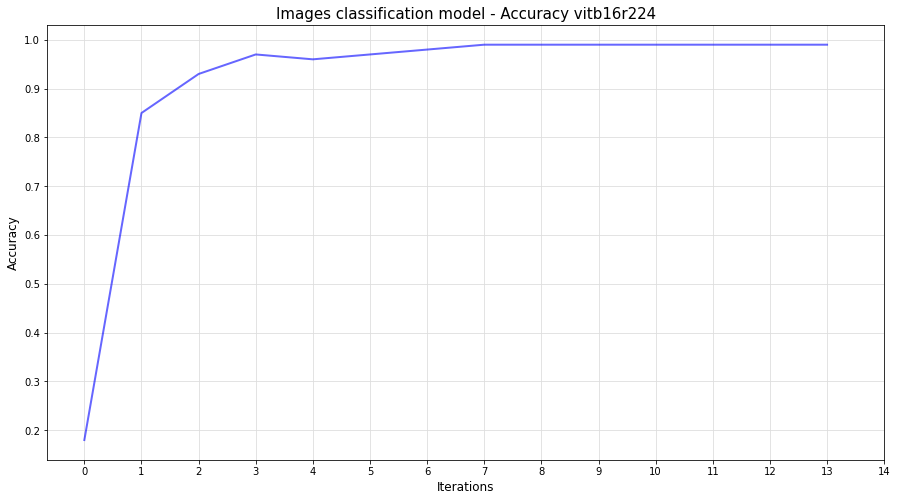

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(automlvisionmetrics['accuracy'], 'b-', lw = 2, alpha = 0.6)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.title('Images classification model - Accuracy ' + best_child_run.properties['run_algorithm'], 
          fontsize = 15)
plt.grid(color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))

plt.savefig(MODEL_DIR + '/accuracy_bestmodel.png')
plt.show()

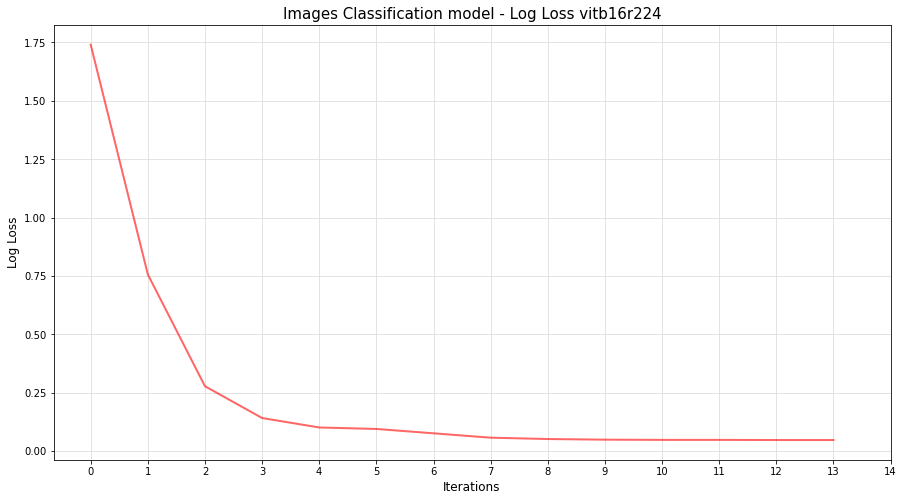

In [76]:
%matplotlib inline

plt.figure(figsize = (15, 8))
plt.plot(automlvisionmetrics['log_loss'], 'r-', lw = 2, alpha = 0.6)
plt.xlabel('Iterations', fontsize = 12)
plt.ylabel('Log Loss', fontsize = 12)
plt.title('Images Classification model - Log Loss ' + best_child_run.properties['run_algorithm'],
          fontsize = 15)
plt.grid(color='#DDDDDD', linewidth = 0.8)
plt.xticks(np.arange(0, 15, 1))

plt.savefig(MODEL_DIR + '/logloss_bestmodel.png')
plt.show()

## 8. Register the optimal CV model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [77]:
from azureml.core import Run
hyperdrive_run = Run(experiment = experiment, 
                     run_id = automl_image_run.id + '_HD')
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutomlforImages-FlowersClassification,AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [78]:
# Register the best model from the AutoML Vision run
best_child_run = automl_image_run.get_best_child()

In [79]:
best_child_run.properties

{'_azureml.ComputeTargetType': 'amlctrain',
 'ContentSnapshotId': '1d4295b6-dac0-4395-a353-b7254ed1753c',
 'ProcessInfoFile': 'azureml-logs/process_info.json',
 'ProcessStatusFile': 'azureml-logs/process_status.json',
 'score': '0.99',
 'model_name': 'AutoML27b99069d9',
 'runTemplate': 'automl_child',
 'run_algorithm': 'vitb16r224',
 'model_output_path': 'outputs/model.pt',
 'scoring_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53_HD_9/outputs/scoring_file_v_1_0_0.py',
 'conda_env_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53_HD_9/outputs/conda_env_v_1_0_0.yml',
 'model_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_27b99069-d2e5-4649-8cf6-04ced154bb53_HD_9/outputs/model.pt'}

In [80]:
cvalgo = best_child_run.properties['run_algorithm']
print(cvalgo)

vitb16r224


In [81]:
# Defining tags for the custom vision model
cvmodel_tags = {
    "Data" : "Images",
    "Algorithm" : cvalgo,
    "Context" : "Flowers Classification",
    "Type" : "Image Classification",
    "Task" : "Azure AutoML for Images",
    "AutoML Metric" : "Accuracy"
}

cvmodel_desc = "Computer vision model to detect flowers from image"

In [82]:
model_name = best_child_run.properties["model_name"]

model = best_child_run.register_model(model_name = model_name,
                                      model_path = "outputs/model.pt",
                                      description = cvmodel_desc,
                                      tags = cvmodel_tags)

In [83]:
# We can download the CV model
model.download(target_dir = "model", 
               exist_ok = True)

'model/model.pt'

In [84]:
listfiles(MODEL_DIR)

Files in: model 

2022-06-14 12:43:17.361887 accuracy_1.png 23.4 kB
2022-06-14 13:14:05.076462 accuracy_bestmodel.png 20.5 kB
2022-06-14 12:42:03.151348 confusion_matrix_1.json 247 Bytes
2022-06-14 13:13:00.217580 confusion_matrix_bestmodel.json 247 Bytes
2022-06-14 12:43:30.878154 logloss_1.png 26.7 kB
2022-06-14 13:14:28.627984 logloss_bestmodel.png 21.4 kB
2022-06-14 13:15:05.047141 model.pt 685.9 MB


### Model informations from the Azure ML model repository

In [85]:
model

Model(workspace=Workspace.create(name='azuremlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='azuremlvision-rg'), name=AutoML27b99069d9, id=AutoML27b99069d9:1, version=1, tags={'Data': 'Images', 'Algorithm': 'vitb16r224', 'Context': 'Flowers Classification', 'Type': 'Image Classification', 'Task': 'Azure AutoML for Images', 'AutoML Metric': 'Accuracy'}, properties={})

In [86]:
model.id, model.name, model.version

('AutoML27b99069d9:1', 'AutoML27b99069d9', 1)

In [87]:
model.tags

{'Data': 'Images',
 'Algorithm': 'vitb16r224',
 'Context': 'Flowers Classification',
 'Type': 'Image Classification',
 'Task': 'Azure AutoML for Images',
 'AutoML Metric': 'Accuracy'}

## 9. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. **You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)).**<br><br> ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage. <br><br>
**In this tutorial, we will deploy the model as a web service in AKS.**
You will need to first create an AKS compute cluster, or use an existing AKS cluster.

In [88]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your inference cluster
aks_name = "aks-clustertest"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace = ws, name = aks_name)
    print('Found existing inference cluster:', aks_name)

except ComputeTargetException:
    print("Creating a new inference cluster...")
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size = "STANDARD_NC6",
                                                        location = "westeurope")
    
    aks_target = ComputeTarget.create(workspace = ws, 
                                      name = aks_name,
                                      provisioning_configuration = prov_config)
    
    aks_target.wait_for_completion(show_output = True)
    
    print("Done. Inference cluster has been created:", aks_name)

Found existing inference cluster: aks-clustertest
CPU times: user 0 ns, sys: 23.2 ms, total: 23.2 ms
Wall time: 112 ms


Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.  
You can then deploy the model as an AKS web service.

In [89]:
aks_tags = {
    "Data": "Images",
    "Algorithm" : cvalgo,
    "Topic" : "Flowers Classification",
    "Task" : "Image Classification",
    "Framework" : "AutoML for Images best model",
    "AKS" : "True"
}

aks_description = "AutoML for Images classification model to detect flowers on images"

In [90]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file("outputs/scoring_file_v_1_0_0.py", 
                             output_file_path = MODEL_DIR + "/score.py")

environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script = MODEL_DIR + "/score.py",
                                   environment = environment)

aks_config = AksWebservice.deploy_configuration(autoscale_enabled = True,                                          
                                                cpu_cores = 1,
                                                memory_gb = 50,
                                                enable_app_insights = True,
                                                description = aks_description,
                                                tags = aks_tags)

In [91]:
listfiles(MODEL_DIR)

Files in: model 

2022-06-14 12:43:17.361887 accuracy_1.png 23.4 kB
2022-06-14 13:14:05.076462 accuracy_bestmodel.png 20.5 kB
2022-06-14 12:42:03.151348 confusion_matrix_1.json 247 Bytes
2022-06-14 13:13:00.217580 confusion_matrix_bestmodel.json 247 Bytes
2022-06-14 12:43:30.878154 logloss_1.png 26.7 kB
2022-06-14 13:14:28.627984 logloss_bestmodel.png 21.4 kB
2022-06-14 13:15:05.047141 model.pt 685.9 MB
2022-06-14 13:15:13.801131 score.py 2.1 kB


In [92]:
with open(os.path.join(MODEL_DIR + "/score.py"), "r") as f:
    print(f.read())

# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------
import os
import tempfile
import logging

from azureml.contrib.services.aml_request import rawhttp
from azureml.automl.core.shared import logging_utilities
from azureml.contrib.services.aml_response import AMLResponse
from azureml.core.model import Model

from azureml.automl.dnn.vision.common.utils import _set_logging_parameters
from azureml.automl.dnn.vision.common.model_export_utils import load_model, run_inference
from azureml.automl.dnn.vision.common.logging_utils import get_logger

from azureml.automl.dnn.vision.classification.inference.score import _score_with_model

TASK_TYPE = 'image-classification'
logger = get_logger('azureml.automl.core.scoring_script_images')


def init():
    global model

    # Set up logging
    _set_logging_parameters(TASK_TYPE, {})

    model_path = os.path.join(os.getenv('AZ

### Let's download the ONNX model file

In [93]:
best_child_run.download_file("train_artifacts/model.onnx",
                             output_file_path = MODEL_DIR + "/model.onnx")

In [94]:
listfiles(MODEL_DIR)

Files in: model 

2022-06-14 12:43:17.361887 accuracy_1.png 23.4 kB
2022-06-14 13:14:05.076462 accuracy_bestmodel.png 20.5 kB
2022-06-14 12:42:03.151348 confusion_matrix_1.json 247 Bytes
2022-06-14 13:13:00.217580 confusion_matrix_bestmodel.json 247 Bytes
2022-06-14 12:43:30.878154 logloss_1.png 26.7 kB
2022-06-14 13:14:28.627984 logloss_bestmodel.png 21.4 kB
2022-06-14 13:15:33.819675 model.onnx 343.3 MB
2022-06-14 13:15:05.047141 model.pt 685.9 MB
2022-06-14 13:15:13.801131 score.py 2.1 kB


### Let's download the labels from the AutoML experiment

In [95]:
best_child_run.download_file("train_artifacts/labels.json", 
                             output_file_path = MODEL_DIR + "/labels.json")

with open(os.path.join(MODEL_DIR + "/labels.json"), "r") as f:
    print(f.read())

["daisy", "dandelion", "roses", "sunflowers", "tulips"]


### Let's download the Conda Env file from the experiment

In [96]:
best_child_run.download_file("outputs/conda_env_v_1_0_0.yml", 
                             output_file_path = MODEL_DIR + "/conda_env_v_1_0_0.yml")

with open(os.path.join(MODEL_DIR + "/conda_env_v_1_0_0.yml"), "r") as f:
    print(f.read())

channels:
- conda-forge
- pytorch
dependencies:
- python=3.7
- pip=21.3.1
- numpy==1.18.5
- libffi=3.3
- pip:
  - azureml-core==1.42.0
  - azureml-mlflow==1.42.0
  - azureml-dataset-runtime==1.42.0
  - azureml-telemetry==1.42.0
  - azureml-responsibleai==1.42.0
  - azureml-automl-core==1.42.0.post1
  - azureml-automl-runtime==1.42.0.post1
  - azureml-train-automl-client==1.42.0.post1
  - azureml-defaults==1.42.0
  - azureml-interpret==1.42.0
  - azureml-train-automl-runtime==1.42.0.post1
  - azureml-automl-dnn-vision==1.42.0
  - azureml-dataprep>=2.24.4
name: project_environment



In [97]:
listfiles(MODEL_DIR)

Files in: model 

2022-06-14 12:43:17.361887 accuracy_1.png 23.4 kB
2022-06-14 13:14:05.076462 accuracy_bestmodel.png 20.5 kB
2022-06-14 13:15:56.672595 conda_env_v_1_0_0.yml 586 Bytes
2022-06-14 12:42:03.151348 confusion_matrix_1.json 247 Bytes
2022-06-14 13:13:00.217580 confusion_matrix_bestmodel.json 247 Bytes
2022-06-14 13:15:34.308394 labels.json 55 Bytes
2022-06-14 12:43:30.878154 logloss_1.png 26.7 kB
2022-06-14 13:14:28.627984 logloss_bestmodel.png 21.4 kB
2022-06-14 13:15:33.819675 model.onnx 343.3 MB
2022-06-14 13:15:05.047141 model.pt 685.9 MB
2022-06-14 13:15:13.801131 score.py 2.1 kB


### Let's deploy the model into Azure Kubernetes Service

In [98]:
endpoint_name = 'flowersclassificationmodel' # Name of the endpoint to generate

In [99]:
%%time
print("Deploying the endpoint model:", endpoint_name, "...")

aks_service = Model.deploy(ws,
                           models = [model],
                           inference_config = inference_config,
                           deployment_config = aks_config,
                           deployment_target = aks_target,
                           name = endpoint_name,
                           overwrite = True)

aks_service.wait_for_deployment(show_output = True)
print("\nDone. Model is deployed:", aks_service.state)

Deploying the endpoint model:  flowersclassificationmodel ...
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-06-14 13:16:26+00:00 Creating Container Registry if not exists.
2022-06-14 13:16:26+00:00 Registering the environment.
2022-06-14 13:16:26+00:00 Use the existing image.
2022-06-14 13:16:30+00:00 Checking the status of deployment flowersclassificationmodel..
2022-06-14 13:24:42+00:00 Checking the status of inference endpoint flowersclassificationmodel.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model is deployed: Healthy
CPU times: user 1.91 s, sys: 322 ms, total: 2.24 s
Wall time: 8min 25s


> Usually it takes a couple of minutes to deploy. You can see the endpoint in Azure ML Studio

In [103]:
#print("Model endpoint:", aks_service.scoring_uri)
print("Model endpoint properties:", aks_service.properties)
print("Model endpoint tags:", aks_service.tags)

Model endpoint properties: {'hasInferenceSchema': 'False', 'hasHttps': 'False', 'authEnabled': 'True'}
Model endpoint tags: {'Data': 'Images', 'Algorithm': 'vitb16r224', 'Topic': 'Flowers Classification', 'Task': 'Image Classification', 'Framework': 'AutoML for Images best model', 'AKS': 'True'}


In [104]:
# You can have access to the logs
#print(aks_service.get_logs())

## 10. Testing the model
Finally, let's test our deployed Computer Vision model to predict new images. You can pass in any image.

In [114]:
def flowers_classification_model(image_file):
    
    t1 = time.time()
    scoring_uri = aks_service.scoring_uri
    key, _ = aks_service.get_keys() # get endpoint keys
    
    print("Predicting image file:", image_file, "\n")
    imagedata = open(image_file, 'rb').read() # Open image file in binary
    headers = {'Content-Type': 'application/octet-stream'}
    headers['Authorization'] = f'Bearer {key}'
    resp = requests.post(scoring_uri, imagedata, headers = headers) # Calling the model
    
    print("Image file:", image_file)
    print("Results:", resp.text)
    
    prediction = json.loads(resp.text) # results in Json
    label_index = np.argmax(prediction['probs']) # Best predicted label
    label = prediction['labels'][label_index]
    conf_score = prediction['probs'][label_index]
    
    print("[Prediction] This flower is a", label, 
          "with a confidence =", round(conf_score * 100, 2), "%")
    
    print("\nResponse status code:", resp.status_code, "Elapsed:", resp.elapsed)
    print("Full process done in", round(time.time() - t1, 4), "seconds.")
    
    return label, conf_score

### Test 1

Image to analyse: flowers-images/test/test (1).jpg


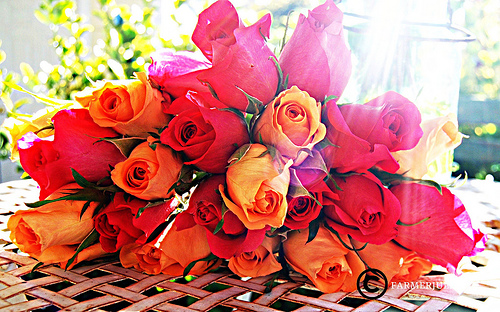

In [108]:
from IPython.display import Image

test1 = TEST_DIR + '/test (1).jpg'
print("Image to analyse:", test1)
Image(filename = test1, width = 512, height = 512)

In [117]:
flowers_classification_model(test1)

Predicting image file: flowers-images/test/test (1).jpg 

Image file: flowers-images/test/test (1).jpg
Results: {"filename": "/tmp/tmp97pdn4yi/tmpxctajhna", "probs": [0.0005343324155546725, 0.00020883162505924702, 0.9914088845252991, 0.0038917118217796087, 0.003956255502998829], "labels": ["daisy", "dandelion", "roses", "sunflowers", "tulips"]}

[Prediction] This flower is a roses with a confidence = 99.14 %

Response status code: 200 Elapsed: 0:00:00.184137
Full process done in 0.835 seconds.


### Test 2

In [ ]:
test2 = TEST_DIR + '/test (2).jpg'
print("Image to analyse:", test2)
Image(filename = test2, width = 512, height = 512)

In [ ]:
flowers_classification_model(test2)

### Test 3

In [ ]:
test3 = TEST_DIR + '/test (3).jpg'
print("Image to analyse:", test3)
Image(filename = test3, width = 512, height = 512)

In [ ]:
flowers_classification_model(test3)

## 11. Clean-up ressources

In [ ]:
compute_target.delete()

> End of notebook